# **Classification problem with Pytorch [DEMO]**

Author: Alejandro Meza Tudela

The goal of this project is to solve a classification problem from start to finish using PyTorch. To achieve this, I will demonstrate a basic workflow that can be easily adapted for other projects.

The steps we will follow are:

- Import a dataset to work with.
- Load the data properly.
- Create or import AI models.
- Build functions to train the model.
- Compare the obtained results.
- Save the trained models.
- Import a custom image and generate a prediction.



## 1. Import dataset

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd

#import torchvision
import torchvision
import torchvision.datasets as datasets #to get a DS to work with
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor #convert a PIL image or numpy.Arrat to tensor --> to use in our model

#import matplotlib for visualization
import matplotlib.pyplot as plt

#check versions
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


For this notebook, we are going to use the dataset SVHN.

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting.

The goal from SVHN is to recognize digits and numbers in natural scene images. SVHN is obtained from house numbers in Google Street View images.

**Overview:**
- 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
- 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data


In [2]:
train_data = datasets.SVHN(
    root="data",
    split="train",
    download=True,
    transform=ToTensor()
)
test_data = datasets.SVHN(
    root="data",
    split="test",
    download=True,
    transform=ToTensor()
)

100%|██████████| 182M/182M [00:43<00:00, 4.14MB/s]


100%|██████████| 64.3M/64.3M [00:12<00:00, 5.06MB/s]


In [3]:
print(f'len(train_data): {len(train_data)}')
print(f'len(test_data): {len(test_data)}')

len(train_data): 73257
len(test_data): 26032


In [4]:
#see the first sample
image, label = train_data[0]
image.shape, label

(torch.Size([3, 32, 32]), 1)

In [5]:
#explore the different classes that are availables in the dataset
classes_labels = np.unique(train_data.labels)
classes_labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

So, we have images with the following charasterisics:
- 3 channels: RGB
- Dimensions of 32x32

## 2. Visualize our data

One important step in ML/DL projects is to understand the nature of our data. So a good step to achieve this, is to... visualize our data!

<class 'torch.Tensor'> <class 'int'>
Image shape: torch.Size([3, 32, 32]), Label: 1


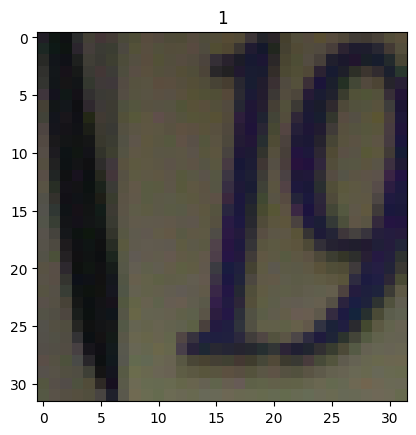

In [6]:
import matplotlib.pyplot as plt

image,label = train_data[0]
print(type(image),type(label))
print(f"Image shape: {image.shape}, Label: {label}")
plt.title(label)
plt.imshow(image.permute(1,2,0))
plt.show()

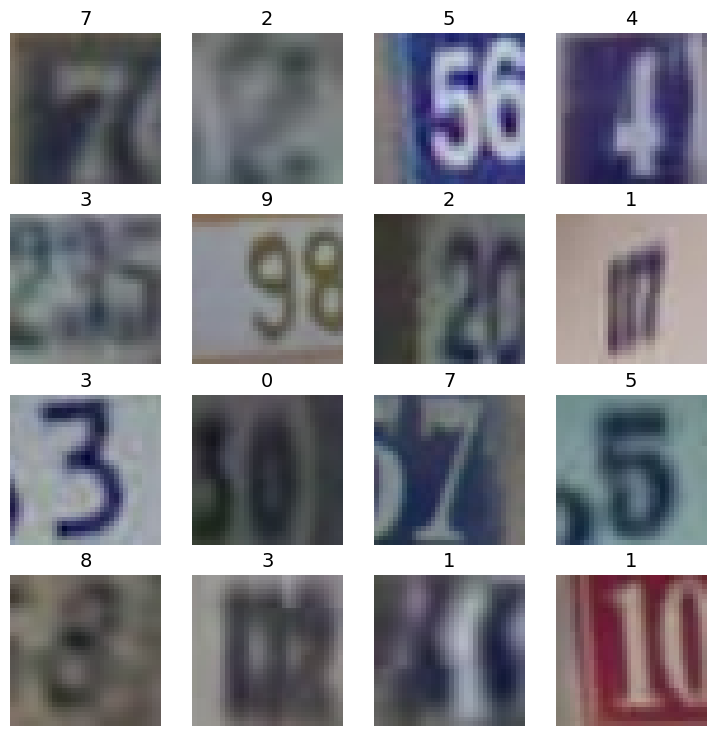

In [7]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.permute(1,2,0))
    plt.title(label, fontsize=14)
    plt.axis(False)

## Setup agnostic code

We will add some code to determine which device will be used to execute our code. It could be a GPU or the default CPU. For this notebook, I recommend using the GPU to achieve faster computation.

In [8]:
#set up device-agnositc code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
!nvidia-smi

Sat Nov 23 02:37:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 3. Creating dataloaders
Dataloaders in PyTorch are responsible for efficiently managing and feeding data to the model during training or evaluation. They handle:

- Batching: Splitting data into manageable chunks.
- Shuffling: Randomizing data order for better training.
- Data Loading: Preprocessing and loading data on-the-fly, avoiding memory overload.

In short, dataloaders streamline the data pipeline, ensuring smooth and efficient model training.


In [10]:
from torch.utils.data import DataLoader

It's important to define our batch size. So, let's give a simple definition about what's a batch size.

Batch size refers to the number of samples processed together in a single forward and backward pass during model training or evaluation.

- A small batch size can provide more frequent updates to the model but might be slower due to overhead.
- A large batch size can speed up processing but requires more memory and may generalize less effectively.

In [11]:
BATCH_SIZE = 32 #define our batch size
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True)
#don't shuffle test data in order to make it easier to evaluate the model performance
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False,drop_last=True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7860f36e3400>,
 <torch.utils.data.dataloader.DataLoader at 0x7860f36e2e90>)

In [12]:
#let's what we have created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} / batches of {BATCH_SIZE}")
print(f"Length of train dataloader: {len(test_dataloader)} / batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7860f36e3400>, <torch.utils.data.dataloader.DataLoader object at 0x7860f36e2e90>)
Length of train dataloader: 2289 / batches of 32
Length of train dataloader: 813 / batches of 32


In [13]:
#let's see how to interact with a batch...
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 32, 32])
Labels batch shape: torch.Size([32])


Image shape: torch.Size([3, 32, 32]), Label: 1


(-0.5, 31.5, 31.5, -0.5)

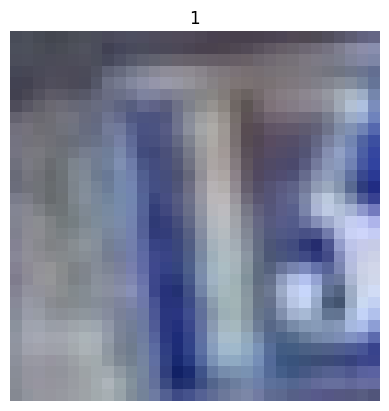

In [14]:
#show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features), size=[1]).item()
image, label = train_features[random_idx], train_labels[random_idx]
print(f"Image shape: {image.shape}, Label: {label}")
plt.title(label.item())
plt.imshow(image.permute(1,2,0))
plt.axis(False)

## 4. Define some models to try

It's time to define some models to try!

### 4.1 TinyVGG

In the first place, we are going to try to implement from scratch TinyVGG.

TinyVGG is a lightweight, simplified convolutional neural network (CNN) architecture inspired by the larger VGGNet (Visual Geometry Group Network). It is commonly used for learning and experimentation purposes, particularly in educational settings or small-scale projects.

You can check the CNN architecture here:
https://poloclub.github.io/cnn-explainer/

In [15]:
#Create a convolutional neuronal network
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
      super().__init__()
      #a block is a group of layers
      self.conv_block_1 = nn.Sequential(
          #create a conv-layer
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(), #layer to apply non-linearity
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(), #layer to apply non-linearity
          nn.MaxPool2d(kernel_size=2,
                       stride=2) #default stride value is the same as kernel size
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(), #layer to apply non-linearity
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(), #layer to apply non-linearity
          nn.MaxPool2d(kernel_size=2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          #there is a trick to calculate this part
          nn.Linear(in_features=hidden_units*25,  #we have to adapt this value depending the output of layer 2
                    out_features=output_shape)
      )

    def forward(self, x):
      x = self.conv_block_1(x)
      #print(f'Shape of block 1: {x.shape}')
      x = self.conv_block_2(x)
      #print(f'Shape of block 2: {x.shape}')
      x = self.classifier(x)
      #print(f'Shape of classifier: {x.shape}')
      return x
      #return self.classifier(self.conv_block_2(self.conv_block_1(x))) --> faster method --> avoid transportation of data through memory

In [16]:
torch.manual_seed(42)
model_tinyvgg = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(classes_labels)
                  ).to(device)
model_tinyvgg

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=250, out_features=10, bias=True)
  )
)

In [19]:
#try a forward pass to check the neural network
image_batch, label_batch = next(iter(train_dataloader))
image_batch = image_batch.to(device)
model_tinyvgg(image_batch)

tensor([[ 0.0317, -0.0458, -0.0925,  0.0996,  0.0678, -0.0282, -0.0378,  0.0422,
          0.0964,  0.0131],
        [ 0.0301, -0.0460, -0.0924,  0.1005,  0.0672, -0.0289, -0.0372,  0.0406,
          0.0975,  0.0127],
        [ 0.0333, -0.0487, -0.0981,  0.1052,  0.0698, -0.0326, -0.0375,  0.0430,
          0.0972,  0.0119],
        [ 0.0294, -0.0456, -0.0911,  0.0998,  0.0676, -0.0264, -0.0374,  0.0407,
          0.0974,  0.0122],
        [ 0.0293, -0.0459, -0.0903,  0.0997,  0.0699, -0.0272, -0.0367,  0.0422,
          0.0979,  0.0124],
        [ 0.0284, -0.0456, -0.0908,  0.0988,  0.0688, -0.0271, -0.0371,  0.0413,
          0.0970,  0.0129],
        [ 0.0317, -0.0467, -0.0942,  0.1026,  0.0679, -0.0292, -0.0362,  0.0428,
          0.0970,  0.0128],
        [ 0.0347, -0.0505, -0.0953,  0.1022,  0.0679, -0.0319, -0.0353,  0.0423,
          0.1003,  0.0122],
        [ 0.0299, -0.0466, -0.0920,  0.0996,  0.0669, -0.0289, -0.0376,  0.0414,
          0.0986,  0.0137],
        [ 0.0331, -

## 4.2 Resnet18

![Resnet18](https://www.researchgate.net/publication/366608244/figure/fig1/AS:11431281109643320@1672145338540/Structure-of-the-Resnet-18-Model.jpg)

ResNet-18 is a deep convolutional neural network with 18 layers designed to address the vanishing gradient problem in very deep networks through the use of residual connections (skip connections). These connections allow the network to learn the identity function and add it to the output of each layer, making it easier to train deep networks.

In [23]:
model_resnet18= torchvision.models.resnet18(weights=True)
model_resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, 10)  # 10 is the number of classes in SVHN
model_resnet18.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2):

In [24]:
#try a forward pass to check the neural network
image_batch, label_batch = next(iter(train_dataloader))
image_batch = image_batch.to(device)
model_resnet18(image_batch)

tensor([[-3.3392e-01,  1.5530e+00, -1.6094e-02, -7.5569e-01,  1.7656e+00,
         -1.4415e+00,  6.0057e-02,  4.0052e-01,  7.1371e-01,  1.1398e+00],
        [ 2.4518e+00,  8.1684e-01, -6.6974e-02,  6.0641e-02,  1.5902e+00,
          1.3067e+00, -1.7557e-01,  8.6713e-01,  2.2381e+00,  2.5817e+00],
        [ 5.7338e-04,  6.5116e-01,  3.5792e-01, -1.0527e-01,  5.6317e-01,
         -2.6961e-01,  7.1593e-01, -2.4859e-01,  2.9059e-01,  6.8398e-01],
        [ 1.8630e+00,  9.9617e-01, -1.9162e-01, -9.4861e-01,  1.1416e+00,
         -3.3185e-01,  1.8665e+00, -1.9524e-02,  7.8098e-01,  1.8376e+00],
        [ 6.8157e-01,  6.2646e-01,  4.4944e-01, -5.6059e-01,  8.9698e-01,
         -1.4561e-01, -7.3702e-02, -4.2636e-01,  7.0107e-01,  2.2672e-01],
        [ 8.3426e-01,  1.6432e-01, -1.1285e+00, -2.3191e-01,  1.9950e+00,
         -4.5757e-01, -6.2286e-01, -4.2753e-01,  1.1930e+00,  3.2921e-01],
        [ 1.5394e-02,  1.7707e-02,  7.5290e-01, -3.2037e-01,  5.5439e-01,
          1.3220e+00, -6.2893e-0

### 4.3 Resnet18 (hugging face pretrained model)

The Hugging Face model in this context refers to a pretrained version of ResNet18, made available through the Hugging Face ecosystem. Hugging Face provides an accessible platform for sharing, downloading, and using pretrained models for a variety of machine learning tasks, including computer vision.

This pretraine model, has used some parameters like:

- batch_size: 128

- epochs: 300

- validation_frequency: 5

- seed: 1

- criterion: CrossEntropyLoss

- criterion_kwargs: {}

- optimizer: SGD

- lr: 0.01

- optimizer_kwargs: {'momentum': 0.9, 'weight_decay': 0.0005}

- scheduler: MultiStepLR

- scheduler_kwargs: {'gamma': 0.1, 'milestones': [75, 100, 150, 225]}

In [38]:
!pip install detectors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.8/616.8 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00


In [39]:
import detectors
import timm

In [45]:
model_resnet18_svh_hugging_face = timm.create_model("resnet18_svhn", pretrained=True)
model_resnet18_svh_hugging_face.to(device)

Downloading: "https://huggingface.co/edadaltocg/resnet18_svhn/resolve/main/pytorch_model.bin" to /root/.cache/torch/hub/checkpoints/resnet18_svhn.pth
100%|██████████| 42.7M/42.7M [00:01<00:00, 37.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_

##5. Obtain information about our models

In order to obtain information about the models, we are going to use torchinfo.

The torchinfo library (formerly known as torchsummary) is a utility for PyTorch that provides a detailed summary of a neural network model's architecture. It is particularly useful for debugging, understanding, and optimizing models by giving insights into their structure and resource requirements.

In [25]:
pip install torchinfo

In [26]:
import torchinfo
from torchinfo import summary

### 5.1 tinyvgg

In [27]:
#this library do a forward pass agaaints the model that we have defined
#TINYVGG
summary(model=model_tinyvgg,
        input_size=(32, 3, 32, 32)
        )

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 10]                  --
├─Sequential: 1-1                        [32, 10, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 10, 30, 30]          280
│    └─ReLU: 2-2                         [32, 10, 30, 30]          --
│    └─Conv2d: 2-3                       [32, 10, 28, 28]          910
│    └─ReLU: 2-4                         [32, 10, 28, 28]          --
│    └─MaxPool2d: 2-5                    [32, 10, 14, 14]          --
├─Sequential: 1-2                        [32, 10, 5, 5]            --
│    └─Conv2d: 2-6                       [32, 10, 12, 12]          910
│    └─ReLU: 2-7                         [32, 10, 12, 12]          --
│    └─Conv2d: 2-8                       [32, 10, 10, 10]          910
│    └─ReLU: 2-9                         [32, 10, 10, 10]          --
│    └─MaxPool2d: 2-10                   [32, 10, 5, 5]            --
├─Sequentia

### 5.2 resnet18

In [28]:
summary(model=model_resnet18,
        input_size=(32, 3, 32, 32)
        )

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [32, 64, 32, 32]          128
├─ReLU: 1-3                              [32, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [32, 64, 16, 16]          --
├─Sequential: 1-5                        [32, 64, 16, 16]          --
│    └─BasicBlock: 2-1                   [32, 64, 16, 16]          --
│    │    └─Conv2d: 3-1                  [32, 64, 16, 16]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 16, 16]          128
│    │    └─ReLU: 3-3                    [32, 64, 16, 16]          --
│    │    └─Conv2d: 3-4                  [32, 64, 16, 16]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 16, 16]          128
│    │    └─ReLU: 3-6                    [32, 64, 16, 16]          --
│

### 5.3 resnet18 (hugging face pretrained version)

In [46]:
summary(model=model_resnet18_svh_hugging_face,
        input_size=(32, 3, 32, 32)
        )

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 32, 32]          1,728
├─BatchNorm2d: 1-2                       [32, 64, 32, 32]          128
├─ReLU: 1-3                              [32, 64, 32, 32]          --
├─Identity: 1-4                          [32, 64, 32, 32]          --
├─Sequential: 1-5                        [32, 64, 32, 32]          --
│    └─BasicBlock: 2-1                   [32, 64, 32, 32]          --
│    │    └─Conv2d: 3-1                  [32, 64, 32, 32]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 32, 32]          128
│    │    └─Identity: 3-3                [32, 64, 32, 32]          --
│    │    └─ReLU: 3-4                    [32, 64, 32, 32]          --
│    │    └─Identity: 3-5                [32, 64, 32, 32]          --
│    │    └─Conv2d: 3-6                  [32, 64, 32, 32]          36,864
│ 

We can see that ResNet18 (pretrained version) has the highest complexity, which might lead to better results. Let's find out!

##6. Define train and test functions

It's time to define some functions that are going to help us in order to perform the train/test loop for our model.

In [29]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device):

  #put the model on train model
  model.train()

  #add evaluation metrics
  train_loss, train_acc = 0, 0

  #TRAIN LOOP
  for batch, (X, y) in enumerate(dataloader):
    #send data to device
    X, y = X.to(device), y.to(device)

    #perform forward pass
    y_pred = model(X)

    #calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    #optimize zero grad
    optimizer.zero_grad()

    #perform backpropagation
    loss.backward()

    #optimizer step
    optimizer.step()

    #calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  #adjust metrics to get the average
  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

In [30]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device):

  #put the model on train model
  model.eval()

  #add evaluation metrics
  test_loss, test_acc = 0, 0

  #TEST LOOP
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      #1. Forward pass
      test_pred_logits = model(X)

      #2. Calculate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      #3. Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

  #adjust metrics to get the average
  test_loss = test_loss/len(dataloader)
  test_acc = test_acc/len(dataloader)
  return test_loss, test_acc

In [31]:
from tqdm.auto import tqdm

#1.Create a train function that takes in various model parameters
def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn,
          epochs: int,
          device: torch.device):

  #2.Creates empty result dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }

  #3.Loop though train and testing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)

    #4.Obtain the results and save them in a dictionary
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

## 7.Train and evaluate our models

For testing purposes, I will use a very small number of epochs. However, if you have sufficient resources, I recommend experimenting with a higher range, such as 50 to 100 epochs, to achieve better model performance.

### 7.1 TinyVGG

In [32]:
torch.manual_seed(42)
model_tinyvgg = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(classes_labels)
                  ).to(device)

In [33]:
optimizer = torch.optim.Adam(params=model_tinyvgg.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss()
number_of_epochs = 3

In [34]:
model_tinyvgg_results = train(model_tinyvgg,train_dataloader,test_dataloader,optimizer,loss_fn,number_of_epochs,device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.8109 | Train acc: 0.3654 | Test loss: 0.8960 | Test acc: 0.7378
Epoch: 2 | Train loss: 0.7620 | Train acc: 0.7722 | Test loss: 0.7515 | Test acc: 0.7849
Epoch: 3 | Train loss: 0.6661 | Train acc: 0.8028 | Test loss: 0.7008 | Test acc: 0.8000


### 7.2 Resnet18

In [35]:
optimizer = torch.optim.Adam(params=model_resnet18.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss()
number_of_epochs = 3

In [36]:
model_resnet18_results = train(model_resnet18,train_dataloader,test_dataloader,optimizer,loss_fn,number_of_epochs,device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.5351 | Train acc: 0.8365 | Test loss: 0.3131 | Test acc: 0.9108
Epoch: 2 | Train loss: 0.2854 | Train acc: 0.9186 | Test loss: 0.2529 | Test acc: 0.9296
Epoch: 3 | Train loss: 0.2244 | Train acc: 0.9359 | Test loss: 0.2292 | Test acc: 0.9355


### 7.3 Resnet18 (hugging face pretrained version)

In [48]:
optimizer = torch.optim.Adam(params=model_resnet18_svh_hugging_face.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss()
number_of_epochs = 3

In [49]:
model_resnet18_svh_hugging_face_results = train(model_resnet18_svh_hugging_face,train_dataloader,test_dataloader,optimizer,loss_fn,number_of_epochs,device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.2919 | Train acc: 0.9150 | Test loss: 0.2396 | Test acc: 0.9325
Epoch: 2 | Train loss: 0.2055 | Train acc: 0.9414 | Test loss: 0.1986 | Test acc: 0.9446
Epoch: 3 | Train loss: 0.1681 | Train acc: 0.9526 | Test loss: 0.1740 | Test acc: 0.9522


## 8. Compare model results

After the train stage, it's time to visualize the obtained results.

In [51]:
model_tinyvgg_results_df = pd.DataFrame(model_tinyvgg_results)
model_resnet18_results_df = pd.DataFrame(model_resnet18_results)
model_resnet18_svh_hugging_face_results_df = pd.DataFrame(model_resnet18_svh_hugging_face_results)

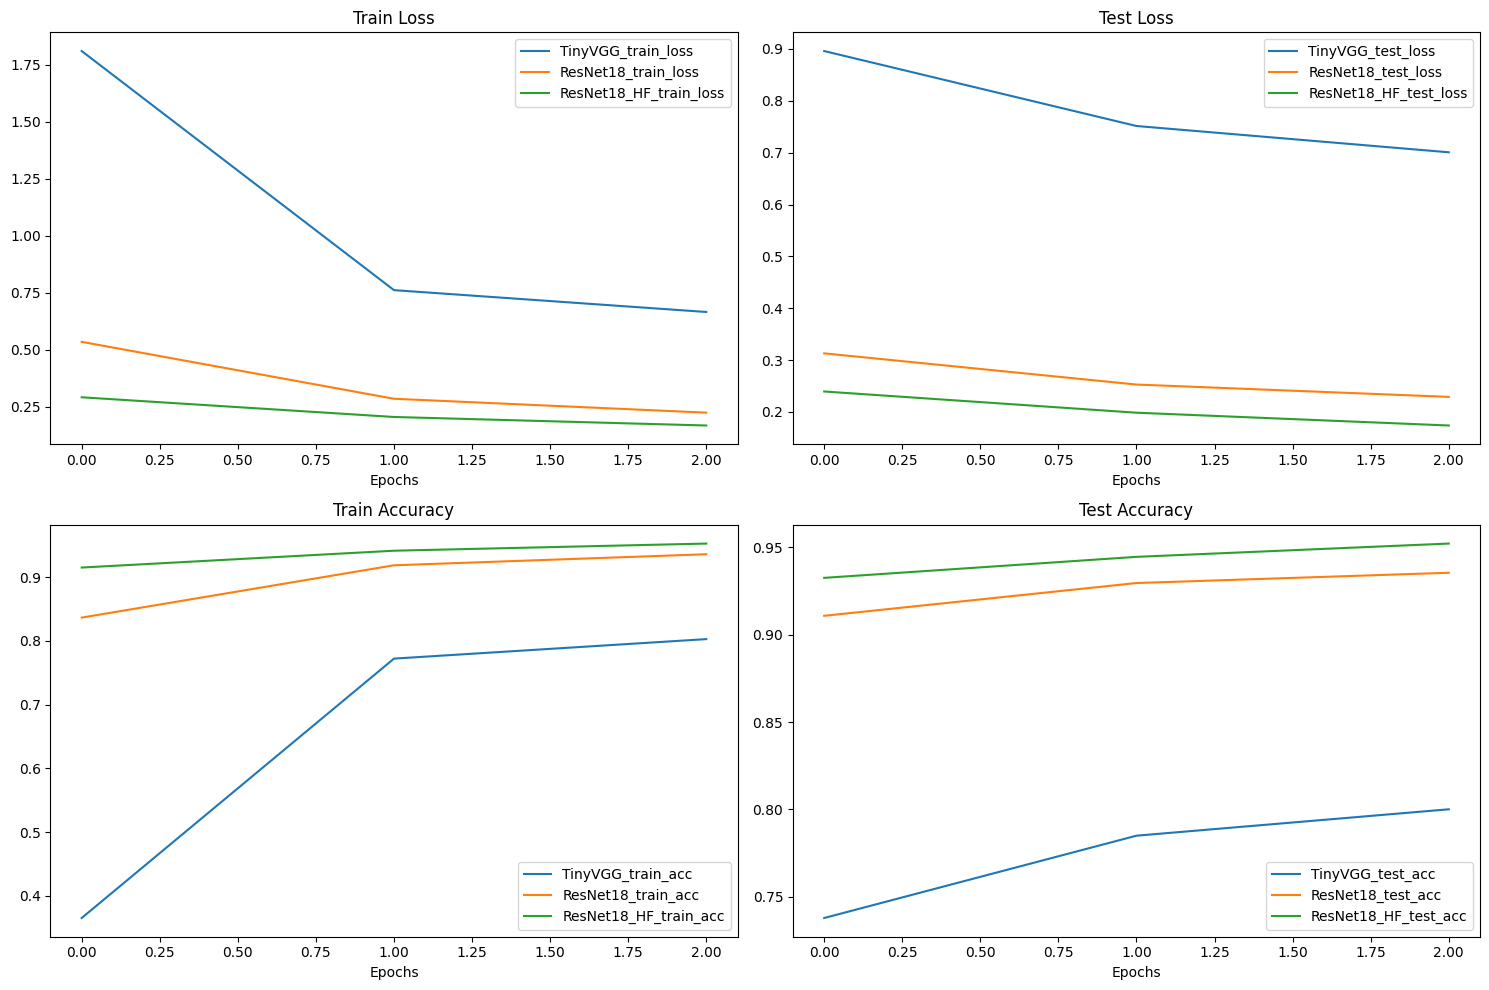

In [52]:
# Create the figure with a specific size
plt.figure(figsize=(15, 10))

# Get the number of epochs (assuming all DataFrames have the same length)
epochs = range(len(model_tinyvgg_results_df))

# Plot Train Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_tinyvgg_results_df['train_loss'], label='TinyVGG_train_loss')
plt.plot(epochs, model_resnet18_results_df['train_loss'], label='ResNet18_train_loss')
plt.plot(epochs, model_resnet18_svh_hugging_face_results_df['train_loss'], label='ResNet18_HF_train_loss')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot Test Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_tinyvgg_results_df['test_loss'], label='TinyVGG_test_loss')
plt.plot(epochs, model_resnet18_results_df['test_loss'], label='ResNet18_test_loss')
plt.plot(epochs, model_resnet18_svh_hugging_face_results_df['test_loss'], label='ResNet18_HF_test_loss')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot Train Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_tinyvgg_results_df['train_acc'], label='TinyVGG_train_acc')
plt.plot(epochs, model_resnet18_results_df['train_acc'], label='ResNet18_train_acc')
plt.plot(epochs, model_resnet18_svh_hugging_face_results_df['train_acc'], label='ResNet18_HF_train_acc')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Plot Test Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_tinyvgg_results_df['test_acc'], label='TinyVGG_test_acc')
plt.plot(epochs, model_resnet18_results_df['test_acc'], label='ResNet18_test_acc')
plt.plot(epochs, model_resnet18_svh_hugging_face_results_df['test_acc'], label='ResNet18_HF_test_acc')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Show the plots
plt.tight_layout()  # Ensures there is no overlap between subplots
plt.show()

**Conclusion**

- ResNet18_HF is the best-performing model in all metrics because it is tailored training strategy on the SVHN dataset, optimized learning rate schedule, and extended training epochs.
  High generalization capabilities resulting from fine-tuning using modern optimization techniques and dataset-specific configurations.
  
- The ResNet18 model is a strong baseline but is slightly less effective than ResNet18_HF for this task. This suggests that while pretrained weights offer a good starting point, fine-tuning can substantially improve performance on a specific dataset like SVHN.

- TinyVGG performs the worst, as expected given its smaller architecture, which is less capable of handling the complexity of the SVHN dataset compared to the deeper ResNet models.

Key Insights:
Fine-tuning pretrained models (like ResNet18_HF) on the target dataset with task-specific configurations significantly enhances performance.
Pretrained general-purpose models (ResNet18) are still effective but benefit from additional training tailored to the dataset.
Simpler models like TinyVGG can be useful for lightweight applications but fall short on complex datasets like SVHN.







## 9. Save models

Saving the weights allows you to reuse the trained model without having to retrain it from scratch, saving time and resources.

Also, storing weights allows you to revisit and analyze the performance of a specific model version. This helps in comparing models, identifying issues, or understanding how different configurations affected training.

In [56]:
save_path = '/content/tinyvgg_weights.pth'
torch.save(model_tinyvgg.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to /content/tinyvgg_weights.pth


In [55]:
save_path = '/content/resnet18_weights.pth'
torch.save(model_resnet18.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to /content/resnet18_weights.pth


In [54]:
save_path = '/content/resnet18_hf_weights.pth'
torch.save(model_resnet18_svh_hugging_face.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to /content/resnet18_hf_weights.pth


In order to load a model, something like this its necessary:

In [63]:
import torchvision.models as models

# Define your model architecture
model_resnet18_hugging_face_load = models.resnet18(weights=None)  # Make sure the architecture matches the saved weights
model_resnet18_hugging_face_load.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
model_resnet18_hugging_face_load.fc = nn.Linear(model_resnet18.fc.in_features, 10)  # 10 is the number of classes in SVHN
model_resnet18_hugging_face_load.to(device)

# Load the weights
weights_path = '/content/resnet18_hf_weights.pth'
state_dict = torch.load(weights_path, weights_only=True)
model_resnet18_hugging_face_load.load_state_dict(state_dict, strict=False)

print("Weights loaded successfully!")

Weights loaded successfully!


## 10. Make an inference over an uploaded image

Let's upload our own data, and try to do a simple predictions over it.

In [85]:
from google.colab import files

# Upload an image file
uploaded = files.upload()

# Get the uploaded image file name
image_file = list(uploaded.keys())[0]
print(f"Uploaded file: {image_file}")

Saving 1.png to 1.png
Uploaded file: 1.png


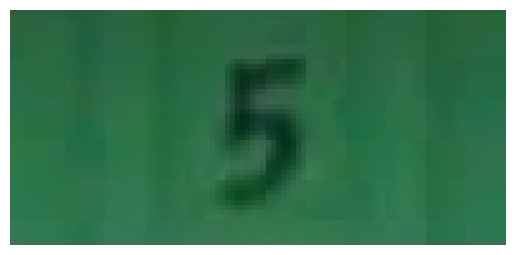

In [86]:
from PIL import Image
# Open the image and convert it to RGB (ensure it has 3 channels)
img = Image.open(image_file).convert("RGB")
# Visualize the image
plt.imshow(img)
plt.axis("off")
plt.show()


In [87]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),   # Resize to SVHN dataset image size
    transforms.ToTensor(),        # Convert to PyTorch tensor
])

# Apply transformations
img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
print(f"Image tensor shape: {img_tensor.shape}")

Image tensor shape: torch.Size([1, 3, 32, 32])


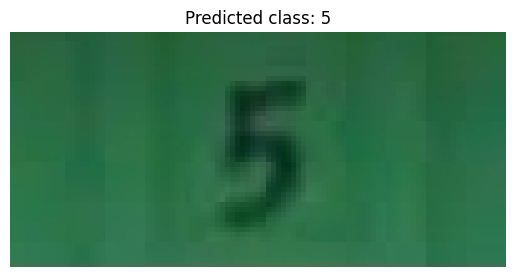

In [103]:
# Make predictions
model_resnet18_svh_hugging_face.eval()
with torch.no_grad():
    output = model_resnet18_svh_hugging_face(img_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

plt.title(f'Predicted class: {predicted_class}')
plt.imshow(img)
plt.axis("off")
plt.show()

As we can see, the class has been correctly predicted, which indicates that our model has successfully made the right classification. This demonstrates that the model is functioning as expected for this particular task.

In this project, we have walked through the basic flow of a classification problem using PyTorch, from start to finish. We began by importing and preparing the dataset, followed by setting up the model architecture. We then proceeded with the training process, evaluating the model's performance, and fine-tuning as needed. After that, we saved the trained model, which can now be used for making predictions on new, unseen data.

By following this workflow, we have not only solved a classification problem but also gained an understanding of the essential components involved in a typical machine learning pipeline with PyTorch. This includes data handling, model creation, training, evaluation, and making predictions, all of which are foundational skills for working with deep learning models.